# Deep Learning: Sentiment Analysis

- In this unit, we will build a deep-learning-based sentiment classifier on the movie reviews from `ntlk`.

![](../images/keras-workflow.png)

## Prepare Data

In [1]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label == "pos" else (text, 0)
             for (text, label) in documents]

random.shuffle(documents)

In [3]:
documents[1]

("jonathan demme ' s _beloved_ , based on the book toni morrison , is a study in skillful literary adaptation . on the one hand , the film manages to recreate key moments from the novel , evoking morrison ' s pragmatic narrative style without using her authorial voice . on the other hand , beloved omits the some of the finer details of the book , favoring an ambiguously defined back story upon which to build the story ' s main events . this choice is a smartly made one , for it creates an open space in which the story ' s wide range of emotions can gestate and grow . indeed , the impact of the film is so protracted that much of it cannot be felt until long after the end credits have rolled . _beloved_ takes place in the second half of the 19th century , during the so - called reconstruction era after the civil war . for newly - freed slaves , it is a time of confusion and turmoil . oprah winfrey is sethe , a slave who escaped a kentucky plantation and took her children to an ohio farmh

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- For text vectorization, we will implement two alternatives:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of all word tokens in texts and we will learn token **embeddings** along with the networks

- Important Steps:
    - Split data into X (texts) and y
    - Initialize `Tokenizer`
    - Use the `Tokenizer` for `text_to_sequences()` or `text_to_matrix`
    - Padding the squences to unigram lengths if needed
    

In [5]:
## Dependencies
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D


In [6]:
## Split data into X (texts) and y (labels)
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set]

In [7]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- Important Notes:
    - We set the `num_words` at **10000**, meaning that the `Tokenizer` will automatically include only the most frequent **10000** words in the vocabulary for analysis.
    - In other words, when we perform `text_to_sequences()` later, the `Tokenizer` will automatically remove words that are NOT in the vocabulary (top 10000 words).

In [8]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- if `oov_token` is specified, then the vocabulary size needs to be added one more.

In [9]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10001


In [10]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('his', 15),
 ('this', 16),
 ('film', 17),
 ('i', 18),
 ('he', 19),
 ('but', 20)]

In [11]:
len(tokenizer.word_index)

37778

## Define X and Y (Text Vectorization)

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [12]:
texts_ints = tokenizer.texts_to_sequences(texts)

In [13]:
print(len(texts[1000].split(' '))) ## original text word number
print(len(texts_ints[1000])) ## sequence token number

925
753


#### Padding

:::{tip}
When dealing with texts and documents, padding each text to the maximum length may not be ideal. For example, for sentiment classification, it is usually the case that authors would highlight more his/her sentiment at the end of the text. Therefore, we can specify an arbitrary `max_len` in padding the sequences to (a) reduce the risk of including too much noise in our model, and (b) speed up the training steps.
:::

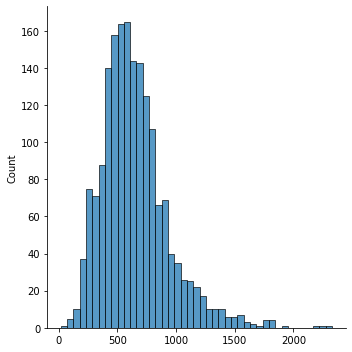

In [14]:
## Check the text len distribution
texts_lens = [len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)

In [15]:
## Find the maxlen of the texts
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2329

- In this tutorial, we consider only the **final** 400 tokens of each text, using the following parameters for `pad_sequences()`.
    - We keep the final 400 tokens from the text (`truncating='pre'`)
    - If the text is short than 400 tokens, we pad the text to 400 tokens at the beginning of the text (`padding='pre'`)

In [16]:
## Padding
max_len = 400
texts_ints_pad = sequence.pad_sequences(texts_ints,
                                        maxlen=max_len,
                                        truncating='pre',
                                        padding='pre')
texts_ints_pad[:10]

array([[4251,  152,    3, ..., 2276, 2276, 1357],
       [   5,  847,   81, ...,    1,   75,   98],
       [  11, 9433, 2785, ...,  141,   75,  431],
       ...,
       [8766,    7,    2, ...,  691,    5,  421],
       [4560,    1, 1042, ..., 6307,   21,  134],
       [   0,    0,    0, ...,  110,   72,   14]], dtype=int32)

In [17]:
## Gereate X and y for training 
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)


## Gereate X and y for testing in the same way
X_test_texts = [n for (n, l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding/Bag-of-Words)

In [19]:
## Texts to One-Hot Encoding (bag of words)
texts_matrix = tokenizer.texts_to_matrix(texts, mode="binary")
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)


## Same for Testing Data
X_test2 = tokenizer.texts_to_matrix(X_test_texts,
                                    mode="binary").astype('int32')
y_test2 = np.array([l for (n, l) in test_set])

In [20]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Hyperparameters

In [21]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

## Model Definition

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.002.jpeg)

In [23]:
## Model 1
model1 = Sequential()
model1.add(Input(shape=(NUM_WORDS, )))
model1.add(Dense(16, activation="relu", name="dense_layer_1"))
model1.add(Dense(16, activation="relu", name="dense_layer_2"))
model1.add(Dense(1, activation="sigmoid", name="output"))

model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

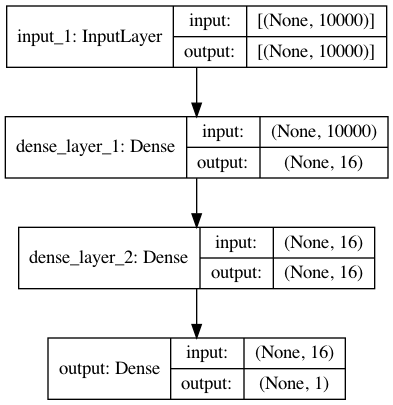

In [24]:
plot_model(model1, show_shapes=True)

In [25]:
history1 = model1.fit(X_train2,
                      y_train2,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 3s - loss: 0.6732 - accuracy: 0.5562 - val_loss: 0.6219 - val_accuracy: 0.6750
Epoch 2/25
12/12 - 0s - loss: 0.5089 - accuracy: 0.8104 - val_loss: 0.5079 - val_accuracy: 0.8194
Epoch 3/25
12/12 - 0s - loss: 0.3043 - accuracy: 0.9632 - val_loss: 0.4258 - val_accuracy: 0.8333
Epoch 4/25
12/12 - 0s - loss: 0.1547 - accuracy: 0.9896 - val_loss: 0.3574 - val_accuracy: 0.8583
Epoch 5/25
12/12 - 0s - loss: 0.0743 - accuracy: 0.9979 - val_loss: 0.3334 - val_accuracy: 0.8583
Epoch 6/25
12/12 - 0s - loss: 0.0376 - accuracy: 0.9993 - val_loss: 0.3284 - val_accuracy: 0.8528
Epoch 7/25
12/12 - 0s - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.3401 - val_accuracy: 0.8528
Epoch 8/25
12/12 - 0s - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.3396 - val_accuracy: 0.8556
Epoch 9/25
12/12 - 0s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.3466 - val_accuracy: 0.8583
Epoch 10/25
12/12 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3522 - val_accuracy: 0.8556
Epoch 11/25
12/12 -

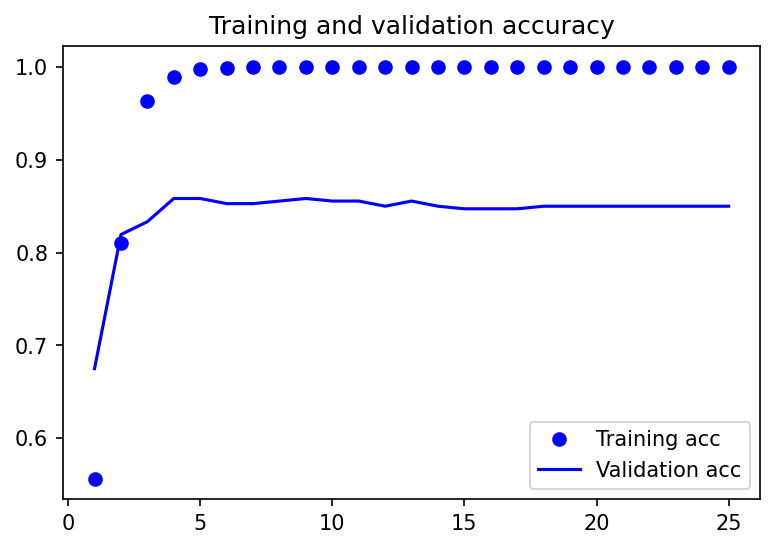

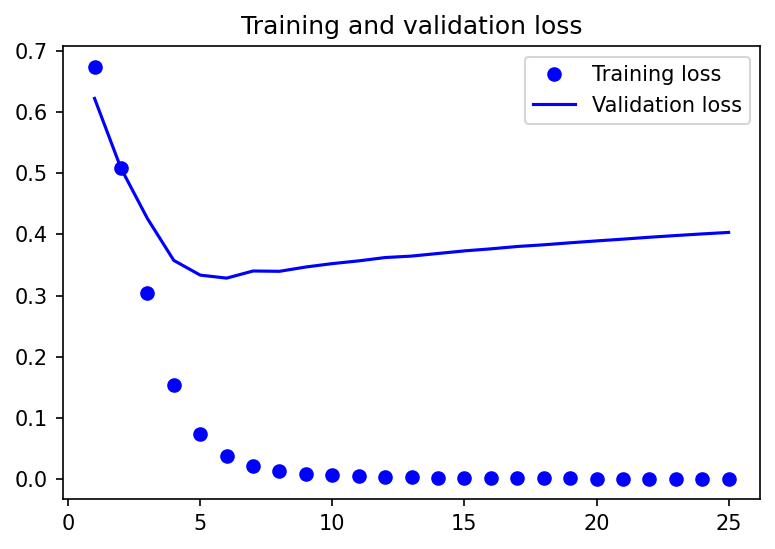

In [26]:
## Plot Training History
plot1(history1)

In [27]:
## Model Evaluation
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3794 - accuracy: 0.8600


[0.379403680562973, 0.8600000143051147]

### Model 2

- One Embedding Layer + Two fully-connected dense layers
- The Inputs are the sequences (integers) of texts.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.004.jpeg)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.008.jpeg)

In [28]:
## Model 2
model2 = Sequential()
model2.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model2.add(
    GlobalAveragePooling1D()
)  ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(Dense(16, activation="relu", name="dense_layer_1"))
model2.add(Dense(16, activation="relu", name="dense_layer_2"))
model2.add(Dense(1, activation="sigmoid", name="output"))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

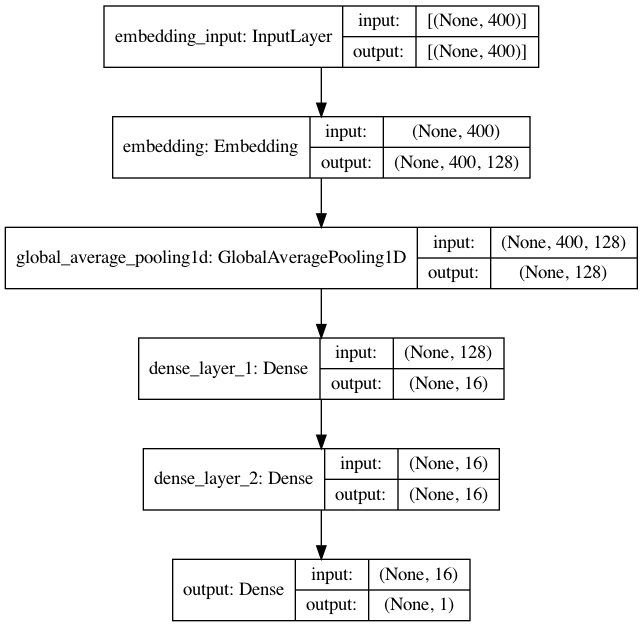

In [29]:
plot_model(model2, show_shapes=True)

In [30]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6928 - accuracy: 0.4951 - val_loss: 0.6923 - val_accuracy: 0.4778
Epoch 2/25
12/12 - 0s - loss: 0.6896 - accuracy: 0.5271 - val_loss: 0.6899 - val_accuracy: 0.4889
Epoch 3/25
12/12 - 0s - loss: 0.6830 - accuracy: 0.6938 - val_loss: 0.6850 - val_accuracy: 0.5444
Epoch 4/25
12/12 - 0s - loss: 0.6705 - accuracy: 0.7681 - val_loss: 0.6770 - val_accuracy: 0.5500
Epoch 5/25
12/12 - 0s - loss: 0.6487 - accuracy: 0.7549 - val_loss: 0.6589 - val_accuracy: 0.6500
Epoch 6/25
12/12 - 0s - loss: 0.6118 - accuracy: 0.8201 - val_loss: 0.6310 - val_accuracy: 0.7250
Epoch 7/25
12/12 - 1s - loss: 0.5535 - accuracy: 0.8785 - val_loss: 0.5904 - val_accuracy: 0.7861
Epoch 8/25
12/12 - 0s - loss: 0.4753 - accuracy: 0.9194 - val_loss: 0.5374 - val_accuracy: 0.8306
Epoch 9/25
12/12 - 1s - loss: 0.3826 - accuracy: 0.9493 - val_loss: 0.4923 - val_accuracy: 0.8222
Epoch 10/25
12/12 - 1s - loss: 0.2930 - accuracy: 0.9660 - val_loss: 0.4348 - val_accuracy: 0.8444
Epoch 11/25
12/12 -

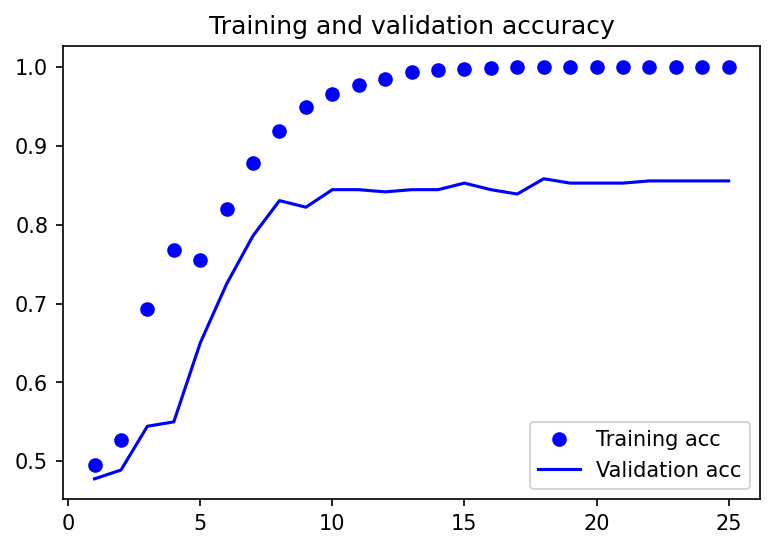

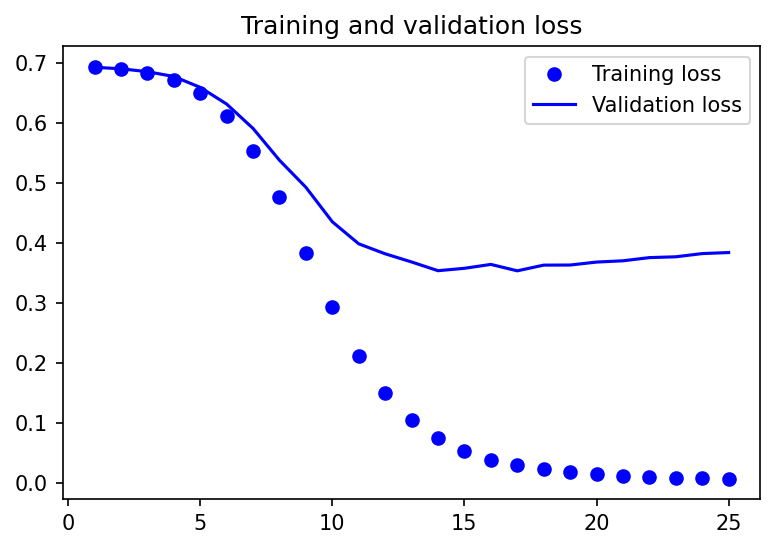

In [31]:
plot1(history2)

In [32]:
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3578 - accuracy: 0.8200


[0.35778099298477173, 0.8199999928474426]

## Issues of Word/Character Representations

- Generally speaking, we can train our word embeddings along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these later.

## Sequence Models

### Model 3

- One Embedding Layer + LSTM + Dense Layer
- Input: the text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.012.jpeg)

In [33]:
## Model 3
model3 = Sequential()
model3.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

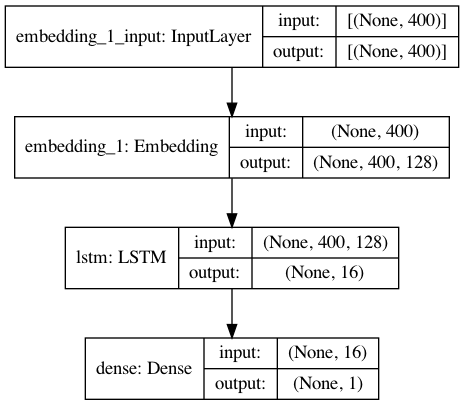

In [34]:
plot_model(model3, show_shapes=True)

In [35]:
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6927 - accuracy: 0.5090 - val_loss: 0.6921 - val_accuracy: 0.5306
Epoch 2/25
12/12 - 5s - loss: 0.6811 - accuracy: 0.7632 - val_loss: 0.6897 - val_accuracy: 0.5694
Epoch 3/25
12/12 - 5s - loss: 0.6606 - accuracy: 0.8208 - val_loss: 0.6845 - val_accuracy: 0.5917
Epoch 4/25
12/12 - 5s - loss: 0.6147 - accuracy: 0.8472 - val_loss: 0.6750 - val_accuracy: 0.6083
Epoch 5/25
12/12 - 5s - loss: 0.5130 - accuracy: 0.8535 - val_loss: 0.6515 - val_accuracy: 0.6167
Epoch 6/25
12/12 - 5s - loss: 0.3580 - accuracy: 0.9028 - val_loss: 0.5985 - val_accuracy: 0.6667
Epoch 7/25
12/12 - 5s - loss: 0.2420 - accuracy: 0.9493 - val_loss: 0.5866 - val_accuracy: 0.6917
Epoch 8/25
12/12 - 5s - loss: 0.1656 - accuracy: 0.9722 - val_loss: 0.5699 - val_accuracy: 0.7167
Epoch 9/25
12/12 - 5s - loss: 0.1249 - accuracy: 0.9799 - val_loss: 0.5688 - val_accuracy: 0.7389
Epoch 10/25
12/12 - 5s - loss: 0.0985 - accuracy: 0.9826 - val_loss: 0.5879 - val_accuracy: 0.7444
Epoch 11/25
12/12 -

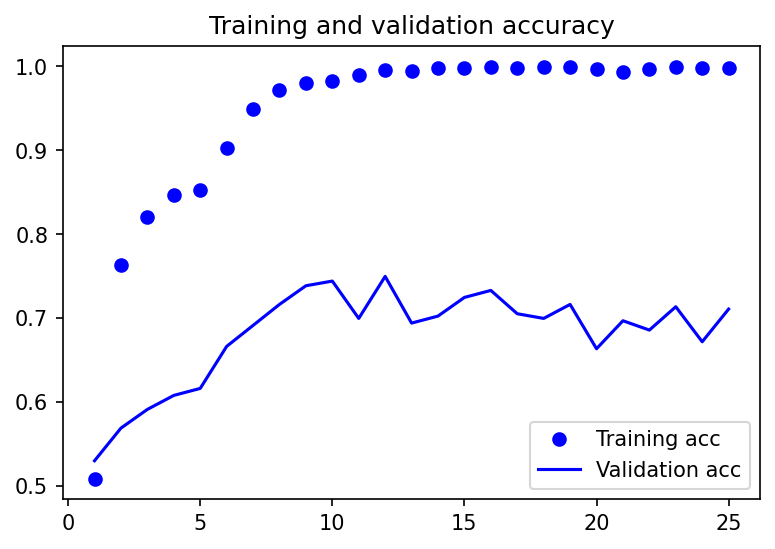

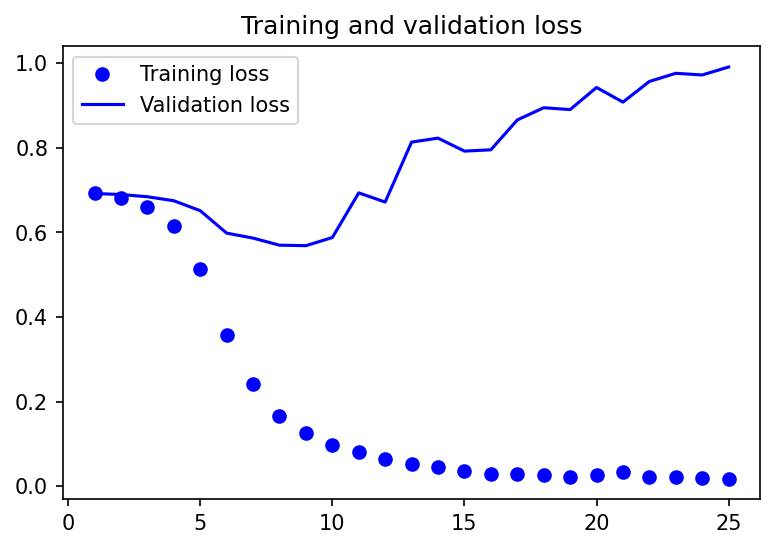

In [36]:
plot1(history3)

In [37]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.7513 - accuracy: 0.7600


[0.7512649297714233, 0.7599999904632568]

### Model 4

- One Embedding Layer + Two Stacked LSTM + Dense Layer
- Inputs: text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.013.jpeg)

In [38]:
## Model 4
model4 = Sequential()
model4.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.2,
                recurrent_dropout=0.2))  #)
model4.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

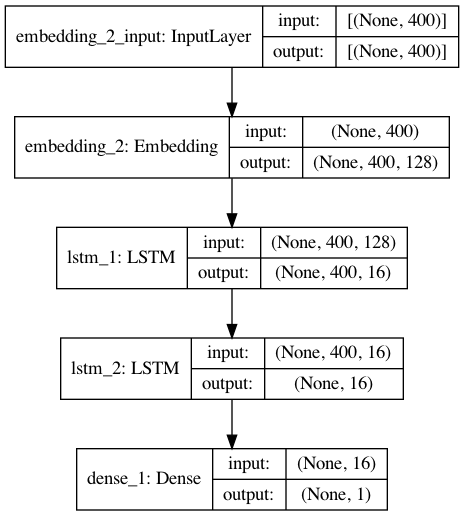

In [39]:
plot_model(model4, show_shapes=True)

In [40]:
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 15s - loss: 0.6928 - accuracy: 0.5042 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/25
12/12 - 9s - loss: 0.6833 - accuracy: 0.6931 - val_loss: 0.6873 - val_accuracy: 0.5556
Epoch 3/25
12/12 - 9s - loss: 0.6370 - accuracy: 0.7625 - val_loss: 0.6574 - val_accuracy: 0.6056
Epoch 4/25
12/12 - 9s - loss: 0.4496 - accuracy: 0.8500 - val_loss: 0.6522 - val_accuracy: 0.7028
Epoch 5/25
12/12 - 9s - loss: 0.2766 - accuracy: 0.9160 - val_loss: 0.5557 - val_accuracy: 0.7528
Epoch 6/25
12/12 - 9s - loss: 0.1684 - accuracy: 0.9667 - val_loss: 0.6145 - val_accuracy: 0.7556
Epoch 7/25
12/12 - 9s - loss: 0.0976 - accuracy: 0.9868 - val_loss: 0.6793 - val_accuracy: 0.7556
Epoch 8/25
12/12 - 9s - loss: 0.0763 - accuracy: 0.9882 - val_loss: 0.6405 - val_accuracy: 0.7444
Epoch 9/25
12/12 - 9s - loss: 0.0543 - accuracy: 0.9951 - val_loss: 0.6427 - val_accuracy: 0.7722
Epoch 10/25
12/12 - 10s - loss: 0.0472 - accuracy: 0.9951 - val_loss: 0.7461 - val_accuracy: 0.7611
Epoch 11/25
12/12

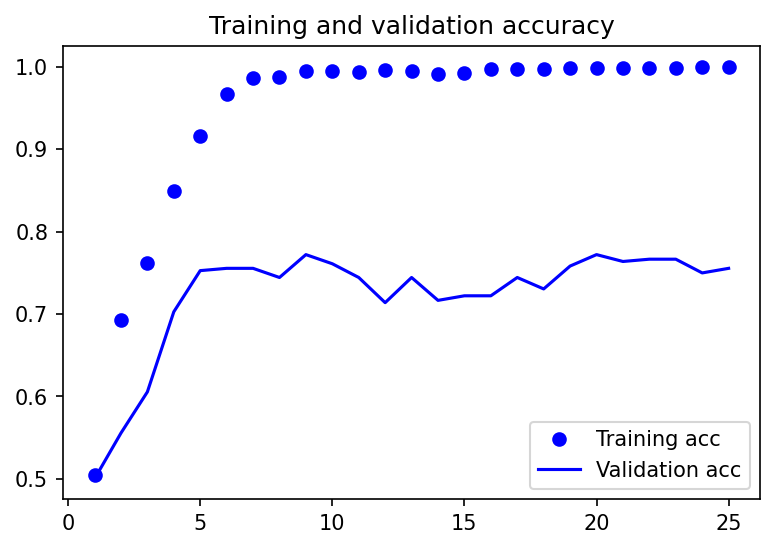

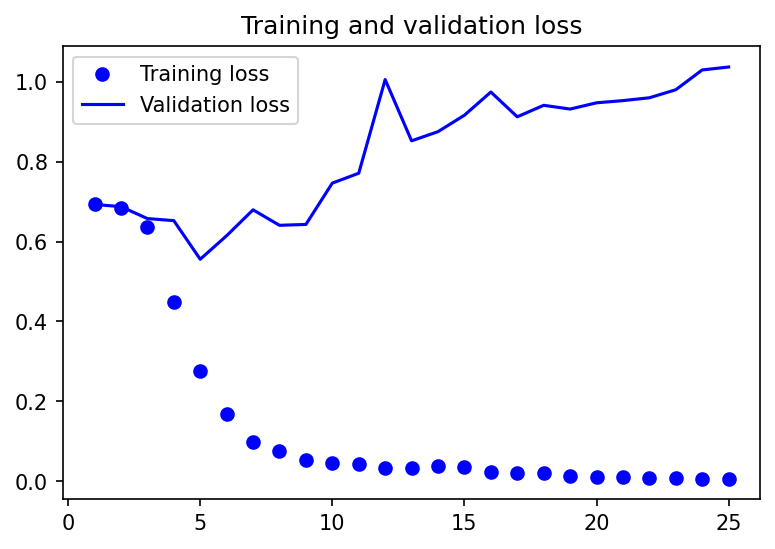

In [41]:
plot1(history4)

In [42]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9985 - accuracy: 0.7500


[0.9984571933746338, 0.75]

### Model 5

- Embedding Layer + Bidirectional LSTM + Dense Layer
- Inputs: Text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.014.jpeg)

In [43]:
## Model 5
model5 = Sequential()
model5.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid"))

model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

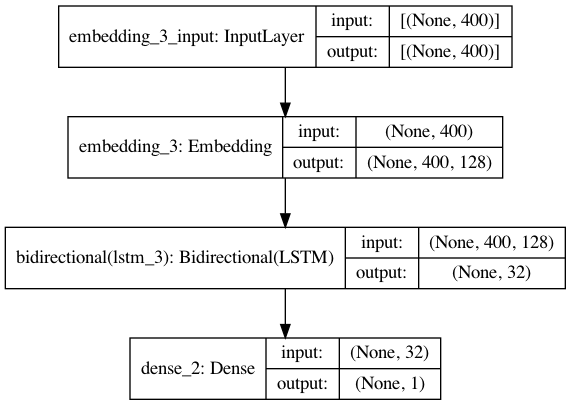

In [44]:
plot_model(model5, show_shapes=True)

In [45]:
history5 = model5.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 22s - loss: 0.6922 - accuracy: 0.5306 - val_loss: 0.6920 - val_accuracy: 0.5556
Epoch 2/25
12/12 - 14s - loss: 0.6764 - accuracy: 0.7903 - val_loss: 0.6906 - val_accuracy: 0.5306
Epoch 3/25
12/12 - 14s - loss: 0.6433 - accuracy: 0.7931 - val_loss: 0.6819 - val_accuracy: 0.5889
Epoch 4/25
12/12 - 16s - loss: 0.5336 - accuracy: 0.8896 - val_loss: 0.6034 - val_accuracy: 0.6778
Epoch 5/25
12/12 - 13s - loss: 0.3515 - accuracy: 0.8951 - val_loss: 0.5983 - val_accuracy: 0.6944
Epoch 6/25
12/12 - 15s - loss: 0.2382 - accuracy: 0.9590 - val_loss: 0.6202 - val_accuracy: 0.6833
Epoch 7/25
12/12 - 13s - loss: 0.1797 - accuracy: 0.9750 - val_loss: 0.5987 - val_accuracy: 0.7306
Epoch 8/25
12/12 - 19s - loss: 0.1180 - accuracy: 0.9847 - val_loss: 0.6442 - val_accuracy: 0.6694
Epoch 9/25
12/12 - 15s - loss: 0.1262 - accuracy: 0.9681 - val_loss: 0.4970 - val_accuracy: 0.7722
Epoch 10/25
12/12 - 14s - loss: 0.0801 - accuracy: 0.9951 - val_loss: 0.4774 - val_accuracy: 0.7917
Epoch 11/

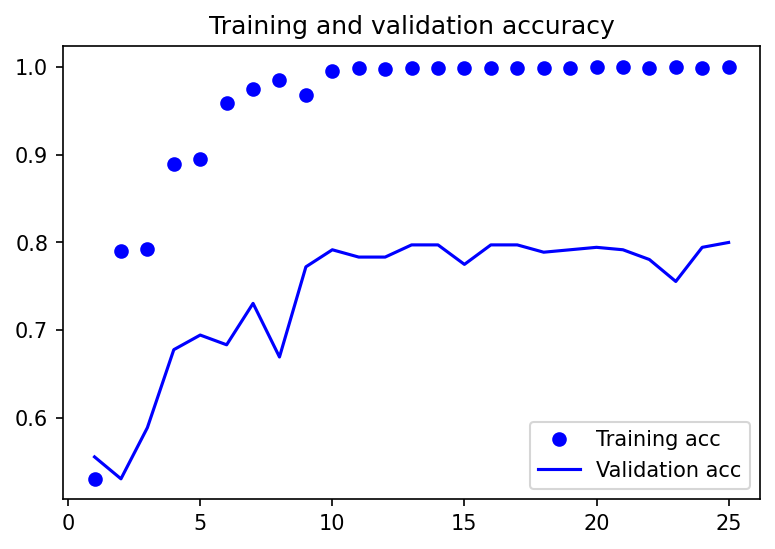

In [46]:
plot1(history5)

In [47]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.6128 - accuracy: 0.7700


[0.6128479242324829, 0.7699999809265137]

## Even More Complex Sequence Models

### Model 6

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer
- Inputs: Text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.015.jpeg)

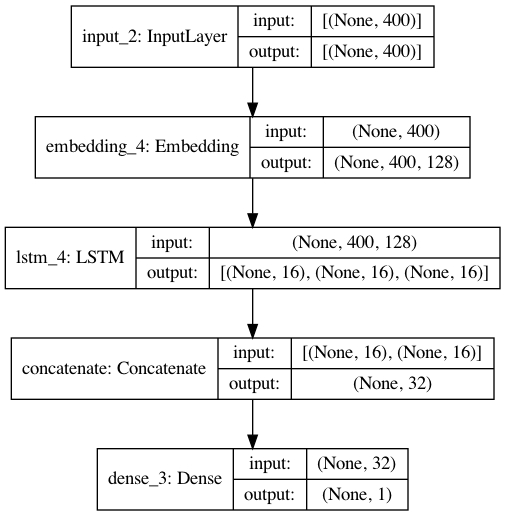

In [48]:
## Model 6

## Functional API
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
_, x_last_h, x_c = LSTM(16,
                        dropout=0.2,
                        recurrent_dropout=0.2,
                        return_sequences=False,
                        return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = Concatenate(axis=1)([x_last_h, x_c])
outputs = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

In [49]:
model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history6 = model6.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 17s - loss: 0.6916 - accuracy: 0.5299 - val_loss: 0.6900 - val_accuracy: 0.5611
Epoch 2/25
12/12 - 10s - loss: 0.6661 - accuracy: 0.7382 - val_loss: 0.6829 - val_accuracy: 0.5972
Epoch 3/25
12/12 - 10s - loss: 0.6107 - accuracy: 0.8326 - val_loss: 0.6610 - val_accuracy: 0.6111
Epoch 4/25
12/12 - 8s - loss: 0.4457 - accuracy: 0.8618 - val_loss: 0.5563 - val_accuracy: 0.7417
Epoch 5/25
12/12 - 8s - loss: 0.2696 - accuracy: 0.8938 - val_loss: 0.6272 - val_accuracy: 0.7333
Epoch 6/25
12/12 - 8s - loss: 0.1586 - accuracy: 0.9556 - val_loss: 0.5082 - val_accuracy: 0.7750
Epoch 7/25
12/12 - 10s - loss: 0.0956 - accuracy: 0.9826 - val_loss: 0.5399 - val_accuracy: 0.7750
Epoch 8/25
12/12 - 9s - loss: 0.0608 - accuracy: 0.9875 - val_loss: 0.5373 - val_accuracy: 0.7528
Epoch 9/25
12/12 - 10s - loss: 0.0446 - accuracy: 0.9924 - val_loss: 0.5683 - val_accuracy: 0.7583
Epoch 10/25
12/12 - 9s - loss: 0.0370 - accuracy: 0.9924 - val_loss: 0.6402 - val_accuracy: 0.7667
Epoch 11/25
12

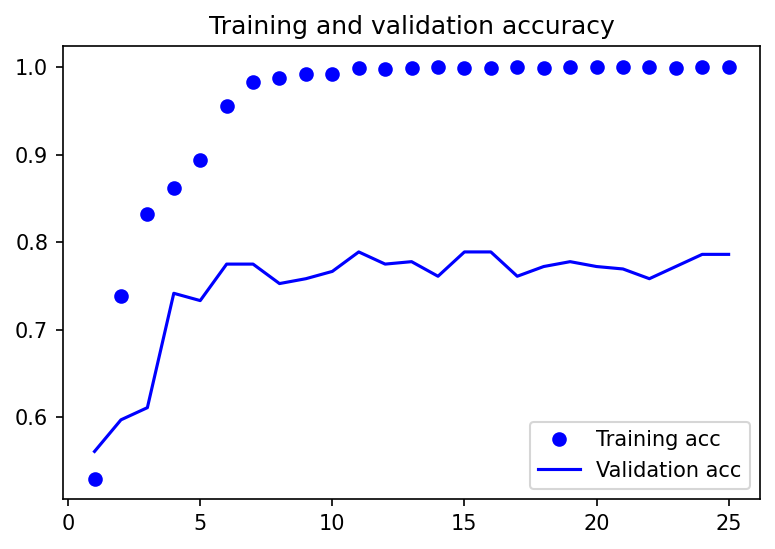

In [50]:
plot1(history6)

In [51]:
model6.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.8351 - accuracy: 0.7900


[0.8351356387138367, 0.7900000214576721]

### Model 7

- Embedding + LSTM + Self-Attention + Dense
- Inputs: Text sequences

- All of the previous RNN-based models only utilize the output of the last time step from the RNN as the input of the decision-making Dense layer.
- We can also make all the hidden outputs at all time steps from the RNN available to decision-marking Dense layer.
- This is the idea of **Attention**.

- Here we add one `Attention` layer, which gives us a weighted version of all the hidden states from the RNN. 
- This is a Self-Attention mechansim.
- The outputs of the self `Attention` layer include information that how each hidden states are connected to each other.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.016.jpeg)

In [52]:
## Model 7 (Self-Attention)

inputs = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = Attention()([x_all_hs, x_all_hs])  # query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

In [53]:
# ## Model 7 (Attention)

# inputs = Input(shape=(max_len,))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)
# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(x)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# ## Self Attention
# atten_out = Attention()([x_last_h, x_all_hs])  # Attention of last hidden states on all preceding states
# atten_out_average = layers.GlobalMaxPooling1D()(atten_out)

# x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
# x = Dense(16, activation="relu")(x_last_h_plus_atten)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [54]:
model7.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history7 = model7.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 28s - loss: 0.6921 - accuracy: 0.5396 - val_loss: 0.6912 - val_accuracy: 0.5611
Epoch 2/25
12/12 - 19s - loss: 0.6782 - accuracy: 0.7639 - val_loss: 0.6820 - val_accuracy: 0.5944
Epoch 3/25
12/12 - 18s - loss: 0.6049 - accuracy: 0.8611 - val_loss: 0.5425 - val_accuracy: 0.7417
Epoch 4/25
12/12 - 20s - loss: 0.3970 - accuracy: 0.8722 - val_loss: 0.4684 - val_accuracy: 0.7972
Epoch 5/25
12/12 - 18s - loss: 0.2213 - accuracy: 0.9347 - val_loss: 0.5525 - val_accuracy: 0.7528
Epoch 6/25
12/12 - 18s - loss: 0.1266 - accuracy: 0.9757 - val_loss: 0.6462 - val_accuracy: 0.7750
Epoch 7/25
12/12 - 19s - loss: 0.0863 - accuracy: 0.9778 - val_loss: 0.5094 - val_accuracy: 0.8111
Epoch 8/25
12/12 - 16s - loss: 0.0292 - accuracy: 0.9951 - val_loss: 0.7152 - val_accuracy: 0.7722
Epoch 9/25
12/12 - 16s - loss: 0.0205 - accuracy: 0.9951 - val_loss: 0.5069 - val_accuracy: 0.8250
Epoch 10/25
12/12 - 17s - loss: 0.0163 - accuracy: 0.9979 - val_loss: 0.6409 - val_accuracy: 0.8222
Epoch 11/

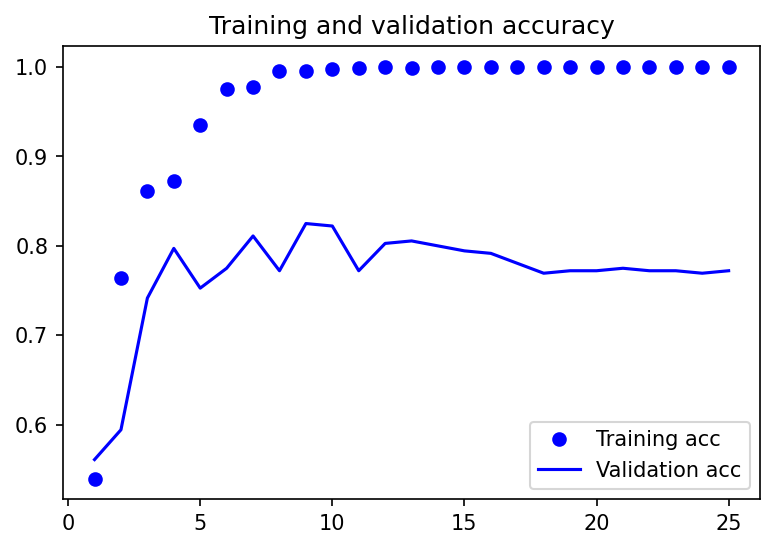

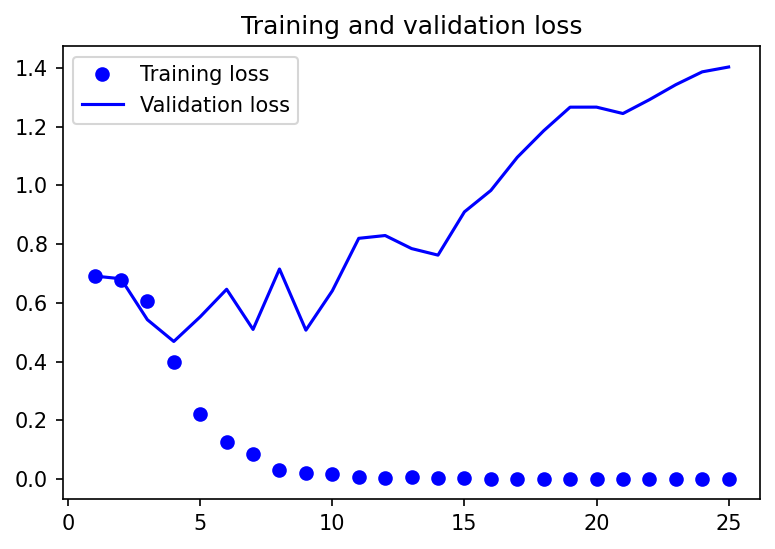

In [56]:
plot1(history7)

In [57]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.3293 - accuracy: 0.7750


[1.3292596340179443, 0.7749999761581421]

## Explanation

- We use LIME for model explanation.
- Let's inspect the Attention-based Model (model7).

In [58]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'],
                              char_level=False)

## Select the best model so far
best_model = model7

In [59]:
## Pipeline for LIME
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    return np.array([[float(1 - x), float(x)]
                     for x in best_model.predict(np.array(_seq_pad))])

In [60]:
text_id = 3
exp = explainer.explain_instance(X_test_texts[text_id],
                                 model_predict_pipeline,
                                 num_features=20,
                                 top_labels=1)
exp.show_in_notebook(text=True)

In [61]:
exp.show_in_notebook(text=True)

## Check Embeddings

- We can also examine the word embeddings learned along with our Classifier.
- Steps include:
    - Extract the embedding weights from the trained model.
    - Determine words we would like to inspect.
    - Extract the embeddings of these words.
    - Use dimensional reduction techniques to plot word embeddings in a 2D graph.

In [62]:
word_vectors = best_model.layers[1].get_weights()[0]
word_vectors.shape

(10001, 128)

In [63]:
## Mapping of embeddings and word-labels
token_labels = [
    word for (ind, word) in tokenizer.index_word.items()
    if ind < word_vectors.shape[0]
]
token_labels.insert(0, "PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [64]:
len(token_labels)

10001

- Because there are many words, we select words for visualization based on the following criteria:
    - Include embeddings of words that are not on the English stopword list (`nltk.corpus.stopwords.words('english')`) and whose word length >= 5 (characters)

In [65]:
from sklearn.manifold import TSNE
stopword_list = nltk.corpus.stopwords.words('english')

In [66]:
out_index = [
    i for i, w in enumerate(token_labels)
    if len(w) >= 5 and w not in stopword_list
]
len(out_index)

8214

In [67]:
out_index[:10]

[27, 68, 70, 73, 80, 81, 93, 98, 101, 102]

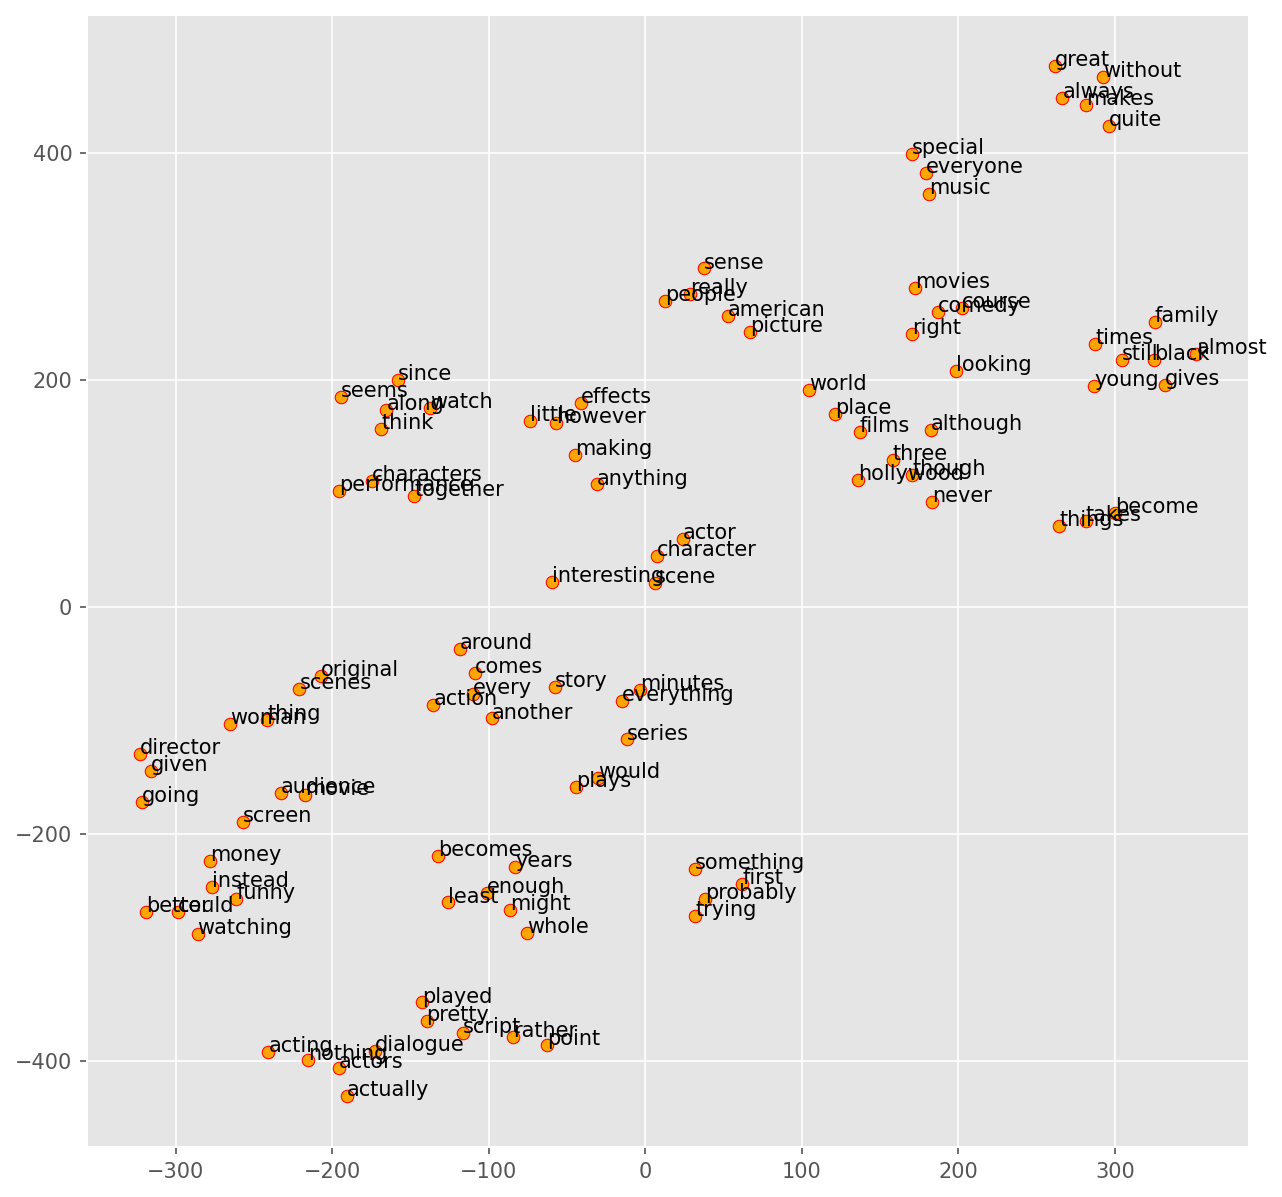

In [79]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100], ])
labels = list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 10), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.01, y + 0.01),
                 xytext=(0, 0),
                 textcoords='offset points')

## Model Comparisons

- Let's compare the learning performance of all the models by examining their changes of accuracies and losses in each epoch of training.

In [69]:
history = [
    history1, history2, history3, history4, history5, history6, history7
]
history = [i.history for i in history]
model_names = [
    'One-hot-dense', 'Embedding-dense', 'RNN', 'Two-RNN', 'Bidirect',
    'Hidden-Cell', 'Self-attention'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

In [70]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

- General Observations
    - Fully-connected network works better with one-hot encoding of texts (i.e., bag-of-words vectorizaed representations of texts)
    - Embeddings are more useful when working with sequence models (e.g., RNN).
    - The self-attention layer, in our current case, is on the entire input sequence, and therefore is limited in its effects.

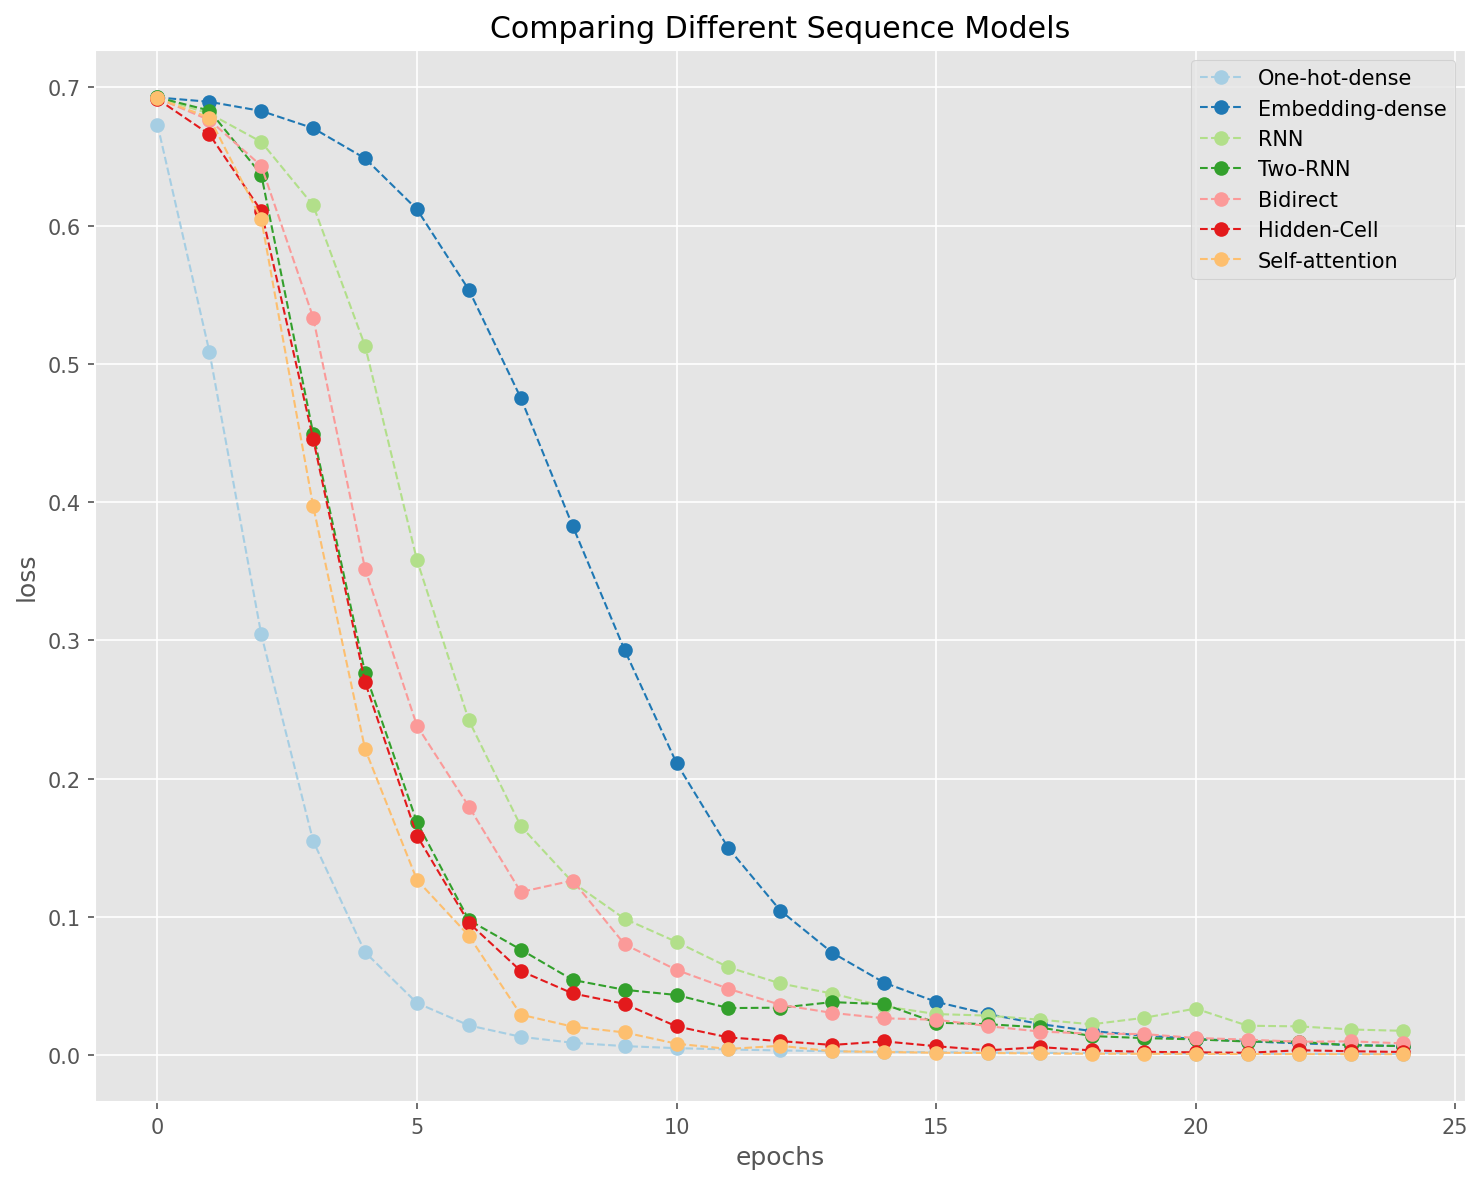

In [71]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()